In [1]:
import torch 
from torch import nn

import os
import pandas as pd
from torch.utils.data import Dataset, Subset
from tqdm import tqdm
import h5py
import torch.nn.functional as F
import numpy as np
from torchvision import transforms

In [36]:
gamma_f= h5py.File("piplus.hdf5", 'r') 

In [3]:
energy = gamma_f['energy'][:]
layer_0 = gamma_f['layer_0'][:]
layer_1 = gamma_f['layer_1'][:]
layer_2 = gamma_f['layer_2'][:]
overflow = gamma_f['overflow'][:]

In [4]:
eplus_f = h5py.File("eplus.hdf5", 'r') 

In [5]:
energy_ep = eplus_f['energy'][:]
layer_0_ep = eplus_f['layer_0'][:]
layer_1_ep = eplus_f['layer_1'][:]
layer_2_ep = eplus_f['layer_2'][:]
overflow_ep = eplus_f['overflow'][:]

In [120]:
trans = transforms.Compose([
    transforms.ToTensor(),
    # transforms.CenterCrop(6),
    transforms.Normalize((0.0), (1.0)),]
)

In [121]:
class CustomImageDataset(Dataset):
    def __init__(self, labels, layer_0, layer_1,layer_02):
        self.labels = labels
        self.layer_0 = layer_0 
        self.layer_1 = layer_1
        self.layer_2 = layer_2
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image1 = layer_0[idx]
        image2 = layer_1[idx]
        # mu, std = np.mean(layer_2[idx]), np.std(layer_2[idx])
        # image3 = (layer_2[idx] - mu) / std
        image3 = trans(layer_2[idx])
        label = self.labels[idx]
        return (image1,image2,image3), label

In [122]:
dataset_gamma = CustomImageDataset(np.ones(100000),layer_0,layer_1,layer_2)
dataset_ep = CustomImageDataset(np.zeros(100000),layer_0_ep,layer_1_ep,layer_2_ep)
total_data = torch.utils.data.ConcatDataset([dataset_gamma, dataset_ep])

In [123]:
N = len(total_data)

# generate & shuffle indices
indices = np.arange(N)
indices = np.random.permutation(indices)
# there are many ways to do the above two operation. (Example, using np.random.choice can be used here too

# select train/test/val, for demo I am using 70,15,15
train_indices = indices [:int(0.7*N)]
val_indices = indices[int(0.7*N):int(0.85*N)]
test_indices = indices[int(0.85*N):]

train_dataset = Subset(total_data, train_indices)
val_dataset = Subset(total_data, val_indices)
test_dataset = Subset(total_data, test_indices)

In [145]:
global batch_size
batch_size = 16

In [146]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1, stride=2)
        self.bn1   = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1, stride=2)
        self.bn2   = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(384, 64)
        self.fc2 = nn.Linear(64, 1)
        

    def forward(self, x, y, z):
        z = z.reshape(batch_size, 1, 12, 6)
        z = F.leaky_relu(self.conv1(z))
        z = self.bn1(F.leaky_relu(self.conv2(z)))
        # print(z.shape)
        z = F.leaky_relu(self.conv3(z))
        # print(z.shape)
        z = self.bn2(F.leaky_relu(self.conv4(z)))
        
        z = z.flatten(start_dim=1)
        
        z = F.leaky_relu(self.fc1(z))
        z = F.leaky_relu(self.fc2(z))
        return z#F.log_softmax(z, dim=-1)

In [147]:
heh = Net()

In [148]:
from torch.utils.data import DataLoader

In [149]:
dataloaders = {'train':DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
               'val':DataLoader(val_dataset, batch_size=batch_size, shuffle=True),
               'test':DataLoader(test_dataset, batch_size=batch_size, shuffle=True)}

In [150]:
loss_fn = nn.BCEWithLogitsLoss()

In [151]:
optimizer = torch.optim.Adam(heh.parameters(), lr=1e-6)

In [152]:
dataloaders['train']

In [153]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    pbar = tqdm(enumerate(dataloaders['train']))
    
    for i, (data,labels) in pbar:
        
        data0,data1,data2 = data
        
        optimizer.zero_grad()
        
        outputs = heh(data0.float(),data1.float(),data2.float())
        
        loss = loss_fn(outputs.float().squeeze(), labels.float())
        loss.backward()
        
        optimizer.step()
        
        if i % 100 == 99:
            pbar.set_description('batch {} loss: {}'.format(i + 1, loss))

    return last_loss

In [154]:
train_loss = []
val_loss = []

## Basically it ain't training

In [ ]:
EPOCHS = 30
epoch_number = 0

best_vloss = 1_00000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    heh.train(True)
    avg_loss = train_one_epoch(epoch_number)
    train_loss.append(avg_loss)
    # We don't need gradients on to do reporting
    heh.train(False)

    running_vloss = 0.0
    for i, (vdata,vlabels) in enumerate(dataloaders['val']):
        vdata0,vdata1,vdata2 = vdata
        voutputs = heh(vdata0.float(),vdata1.float(),vdata2.float())
        vloss = loss_fn(voutputs.float().squeeze(), vlabels.float())
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    val_loss.append(avg_vloss)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation


    # Track best performance, and save the model's state
#     if avg_vloss < best_vloss:
#         best_vloss = avg_vloss
#         model_path = 'model_{}_{}'.format(timestamp, epoch_number)
#         torch.save(heh.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


batch 8700 loss: 0.692940354347229: : 8750it [00:31, 274.58it/s] 


LOSS train 0.0 valid 0.6931793689727783
EPOCH 2:


batch 8700 loss: 0.7041585445404053: : 8750it [02:38, 55.18it/s] 


LOSS train 0.0 valid 0.6931775212287903
EPOCH 3:


batch 8700 loss: 0.6926264762878418: : 8750it [02:07, 68.41it/s] 


LOSS train 0.0 valid 0.6931548118591309
EPOCH 4:


batch 8700 loss: 0.6928288340568542: : 8750it [03:05, 47.07it/s] 


LOSS train 0.0 valid 0.6931663155555725
EPOCH 5:


batch 8700 loss: 0.6933724880218506: : 8750it [00:32, 271.51it/s]


LOSS train 0.0 valid 0.6931530237197876
EPOCH 6:


batch 8700 loss: 0.6929121017456055: : 8750it [01:14, 116.92it/s]


LOSS train 0.0 valid 0.6931483149528503
EPOCH 7:


batch 8700 loss: 0.6931965947151184: : 8750it [00:32, 268.11it/s]


LOSS train 0.0 valid 0.6931477189064026
EPOCH 8:


batch 8700 loss: 0.693550705909729: : 8750it [00:32, 272.19it/s] 


LOSS train 0.0 valid 0.6931504011154175
EPOCH 9:


batch 8700 loss: 0.6942173838615417: : 8750it [00:32, 266.65it/s]


LOSS train 0.0 valid 0.6931516528129578
EPOCH 10:


batch 8700 loss: 0.6935548186302185: : 8750it [00:32, 269.28it/s]


LOSS train 0.0 valid 0.6931540966033936
EPOCH 11:


batch 8700 loss: 0.6929441690444946: : 8750it [00:32, 266.63it/s]


LOSS train 0.0 valid 0.6931512355804443
EPOCH 12:


batch 8700 loss: 0.6935296654701233: : 8750it [00:56, 156.11it/s]


LOSS train 0.0 valid 0.6931502819061279
EPOCH 13:


batch 8700 loss: 0.6932529807090759: : 8750it [00:32, 270.39it/s]


LOSS train 0.0 valid 0.6931516528129578
EPOCH 14:


batch 8700 loss: 0.693681538105011: : 8750it [00:32, 270.51it/s] 


LOSS train 0.0 valid 0.693147599697113
EPOCH 15:


batch 8700 loss: 0.6931645274162292: : 8750it [00:32, 271.46it/s]


LOSS train 0.0 valid 0.6931426525115967
EPOCH 16:


batch 8700 loss: 0.6931378841400146: : 8750it [00:32, 266.54it/s]


LOSS train 0.0 valid 0.6931535601615906
EPOCH 17:


batch 8700 loss: 0.6928552985191345: : 8750it [00:37, 234.37it/s]


LOSS train 0.0 valid 0.6931341290473938
EPOCH 18:


batch 8700 loss: 0.6846450567245483: : 8750it [01:06, 131.48it/s]


LOSS train 0.0 valid 0.6931790113449097
EPOCH 19:


batch 8700 loss: 0.6934871673583984: : 8750it [04:13, 34.47it/s]


LOSS train 0.0 valid 0.6931484937667847
EPOCH 20:


batch 1600 loss: 0.6934977769851685: : 1652it [00:48, 34.04it/s]

In [ ]:
predicts = []
real = []
for i, (vdata,vlabels) in enumerate(dataloaders['test']):
        vdata0,vdata1,vdata2 = vdata
        voutputs = heh(vdata0.float(),vdata1.float(),vdata2.float())
        vloss = loss_fn(voutputs.squeeze(), vlabels)
        pred = voutputs > 0.5
        pred = 1 * pred
        running_vloss += vloss
        for i in pred:
            predicts.append(i.item())
        for i in vlabels:
            real.append(i.item())

from sklearn.metrics import accuracy_score

In [ ]:
print(accuracy_score(real,predicts))

In [160]:
import matplotlib.pyplot as plt

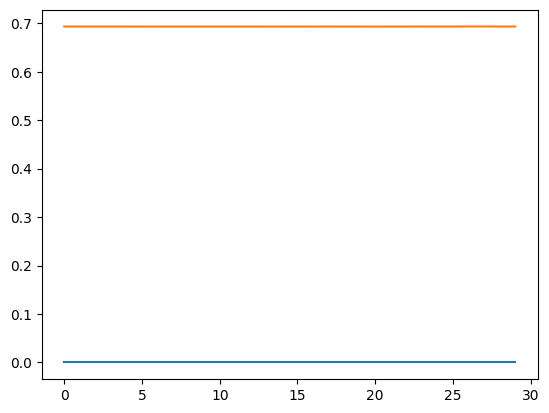

In [161]:
plt.plot(train_loss)
plt.plot([i.item() for i in val_loss])